In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import h5py
import matplotlib.pyplot as plt
from neural_analysis import spectra
from nolitsa import delay, lyapunov
import numpy as np
from scipy import signal
from sklearn.decomposition import PCA
from statsmodels.tsa import stattools
import sys
import time 
from tqdm.notebook import tqdm

sys.path.append('../..')
from utils import *
from nld_utils import *

In [3]:
data_path = '../../__data__/Mary-Anesthesia-20160809-01.mat'
f = h5py.File(data_path, 'r')
dt = get_sample_interval(f, 's')
lfp_areas = [to_string(item, f) for item in f['electrodeInfo']['area'][0]]
dt = get_sample_interval(f, 's')
fs = 1/dt
airPuff_binary, audio_binary = get_binary_stimuli(f)
stimuli = get_stimuli_start_and_end_flags(f)

In [150]:
unit_index = 0
start_time = 4000 # s
duration = 20 # s

start_step = int(start_time/dt)
length = int(duration/dt)

signal_in = f['lfp'][unit_index, start_step:start_step + length]

In [151]:
# spectrogram_kwargs = dict(
#     method='multitaper',
#     spec_type='power',
#     time_width=2,
#     freq_width=1,
#     spacing=0.25,
#     freq_range=[0, 80],
# )

spectrogram_kwargs = dict(
    method='multitaper',
    spec_type='power',
    time_width=0.25,
    freq_width=4,
    spacing=0.05,
    freq_range=[0, 80],
)

k = spectrogram_kwargs['time_width']*fs
r = (spectrogram_kwargs['time_width'] - spectrogram_kwargs['spacing'])*fs
num_timepts = int((length - r)/(k - r))

spec, freq, timepts = spectra.spectrogram(signal_in, fs, **spectrogram_kwargs)

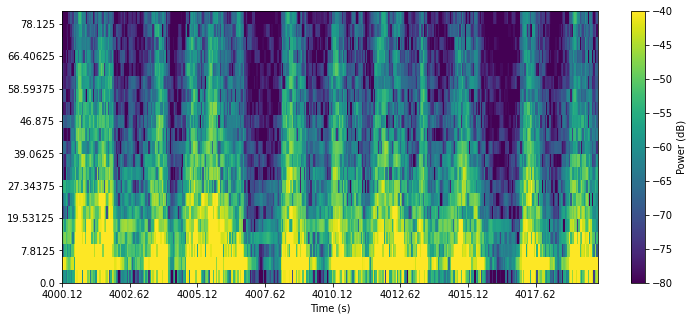

In [152]:
plt.figure(figsize=(12, 5))
plt.pcolormesh(10*np.log10(spec))
xtick_locs = plt.xticks()[0][:-1]
plt.xticks(xtick_locs,[f'{timepts[int(val)] + start_time:.2f}' for val in xtick_locs])
plt.xlabel('Time (s)')
ytick_locs = plt.yticks()[0][:-1]
plt.yticks(ytick_locs,[freq[int(val)]for val in ytick_locs])
plt.colorbar(label='Power (dB)')
plt.clim([-80, -40])
plt.show()

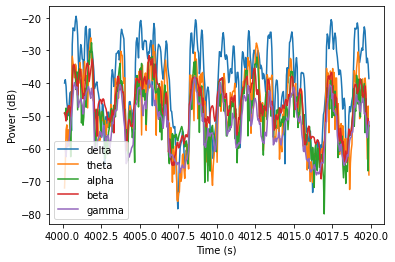

In [153]:
freq_band_power = dict(
    delta=spec[np.logical_and(freq > 0, freq <= 4)].sum(0),
    theta=spec[np.logical_and(freq > 4, freq <= 8)].sum(0),
    alpha=spec[np.logical_and(freq > 8, freq <= 12)].sum(0),
    beta=spec[np.logical_and(freq > 12, freq <= 30)].sum(0),
    gamma=spec[np.logical_and(freq > 30, freq <= 80)].sum(0),
)

for key in freq_band_power.keys():
    plt.plot(timepts + start_time, 10*np.log10(freq_band_power[key]), label=key)
plt.legend()
plt.ylabel('Power (dB)')
plt.xlabel('Time (s)')
plt.show()

## NLD Analysis

In [130]:
# ==============
# INPUTS
# ==============

# LFP ARGS

unit_index = 0
trajectory_start_times = np.arange(0, 7001, 500) # s
duration = 20 # s

# SPECTROGRAM ARGS

spectrogram_kwargs = dict(
    method='multitaper',
    spec_type='power',
    time_width=0.25,
    freq_width=4,
    spacing=0.05,
    freq_range=[0, 80],
)

band = 'theta'

#  NLD ARGS

p = 1
r = 10
theiler_window = 60 # ms
maxt = 100

# ========
trajectory_start_steps = np.int0(trajectory_start_times/dt)
length = int(duration/dt)

results = []

for start_step in tqdm(trajectory_start_steps): 
    lfp_signal = f['lfp'][unit_index, start_step:start_step + length]
    spec, freq, timepts = spectra.spectrogram(lfp_signal, fs, **spectrogram_kwargs)
    freq_band_power = dict(
        delta=spec[np.logical_and(freq > 0, freq <= 4)].sum(0),
        theta=spec[np.logical_and(freq > 4, freq <= 8)].sum(0),
        alpha=spec[np.logical_and(freq > 8, freq <= 12)].sum(0),
        beta=spec[np.logical_and(freq > 12, freq <= 30)].sum(0),
        gamma=spec[np.logical_and(freq > 30, freq <= 80)].sum(0),
    )
    signal_in = freq_band_power[band]
    ret = lyapunov_analysis(signal_in, p=p, r=r, theiler_window=theiler_window, maxt=maxt)
    ret['signal'] = signal_in
    ret['airPuff'] = airPuff_binary[start_step:start_step + length]
    ret['audio'] = audio_binary[start_step:start_step + length]
    ret['start_step'] = start_step
    ret['band'] = band
    ret['freq_band_power'] = freq_band_power
    
    results.append(ret)

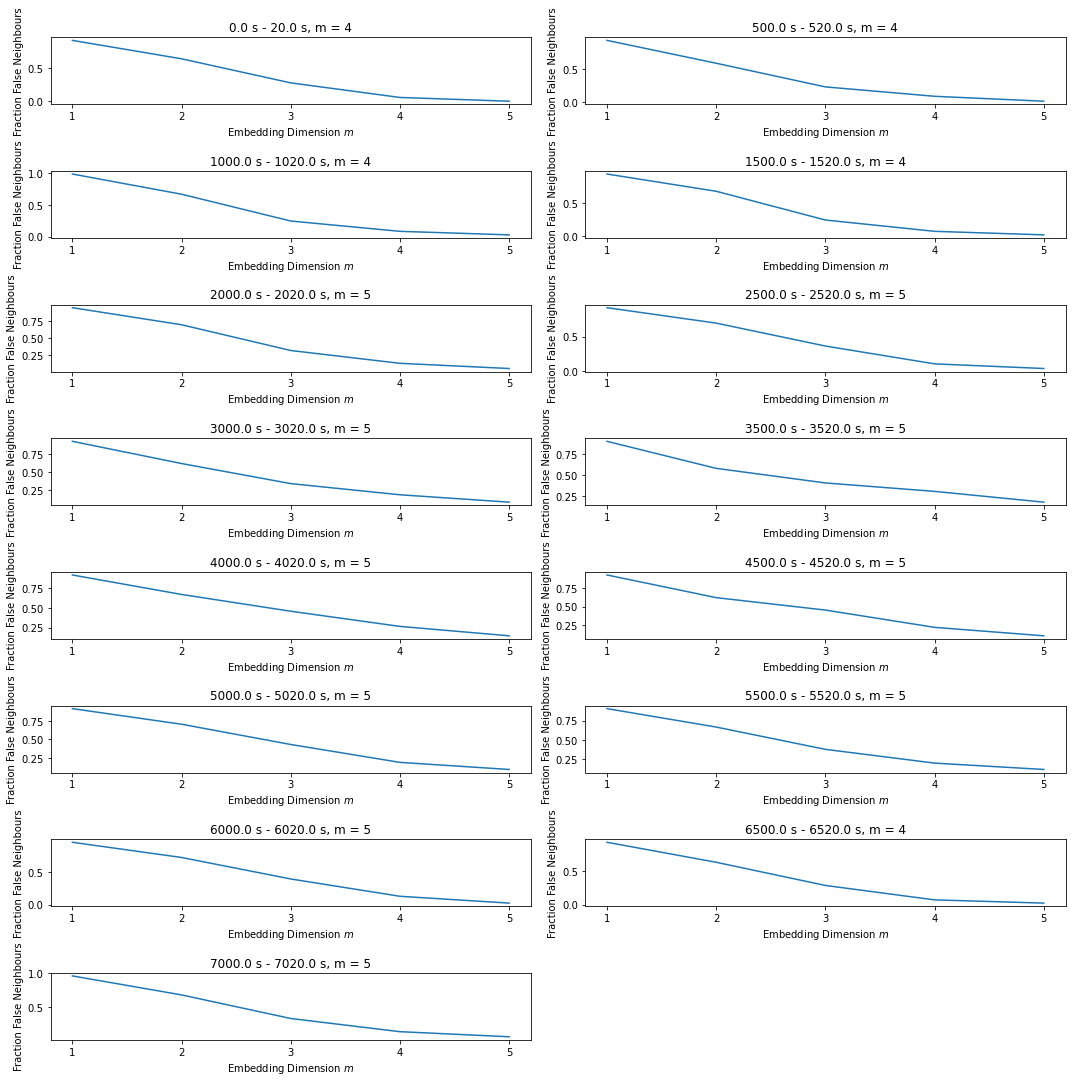

In [131]:
plt.figure(figsize=(15, 15))
for i, ret in enumerate(results):
    plt.subplot(8, 2, i + 1)
    plt.plot(ret['m_vals'], ret['fraction_fnn'])
    plt.xticks(np.arange(1, 6), np.arange(1, 6))
    plt.title(f"{ret['start_step']*dt} s - {ret['start_step']*dt + duration} s, m = {ret['m']}")
    plt.xlabel(r'Embedding Dimension $m$')
    plt.ylabel(r'Fraction False Neighbours')
plt.tight_layout()
plt.show()

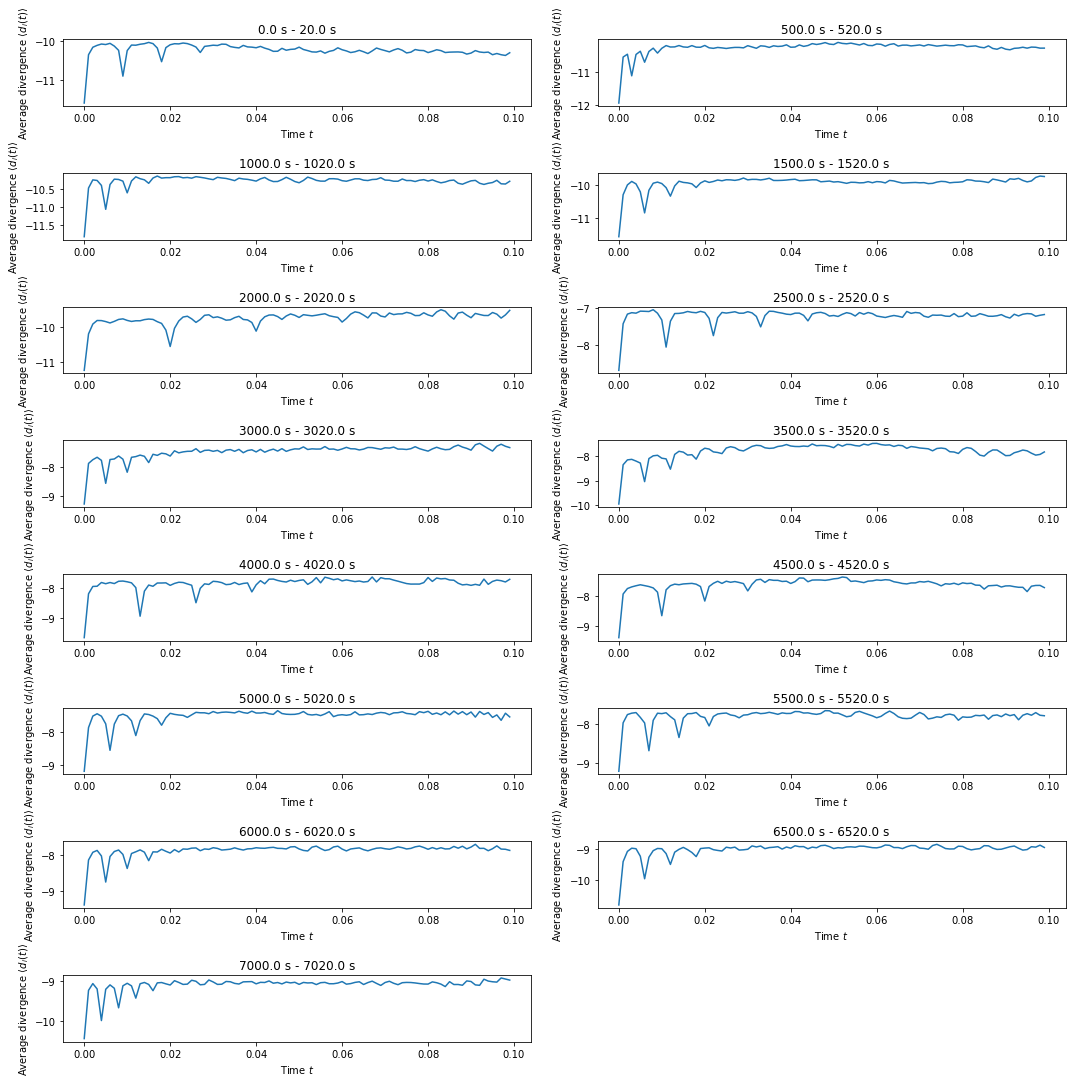

In [132]:
plt.figure(figsize=(15, 15))
for i, ret in enumerate(results):
    plt.subplot(8, 2, i + 1)
    plt.plot(ret['t']*dt, ret['d'])
    plt.title(f"{ret['start_step']*dt} s - {ret['start_step']*dt + duration} s")
    plt.xlabel(r'Time $t$')
    plt.ylabel(r'Average divergence $\langle d_i(t) \rangle$')
plt.tight_layout()
plt.show()